In [1]:
import pandas as pd
import bamboolib as bam
import plotly.express as px
import numpy as np
from datetime import datetime
import re
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn
bam.enable()
url1 = "https://dshs.texas.gov/coronavirus/TexasCOVID19DailyCountyCaseCountData.xlsx"
url2 = "https://dshs.texas.gov/coronavirus/TexasCOVID-19CumulativeTestsOverTimebyCounty.xlsx"
path1 = "./Rt_no_Rolling.csv"
def getExcel(url, sheet, head):
    df = pd.read_excel(url,sheet_name=sheet, header=head)
    df=df.truncate(before=0,after=253)
    return df

df = getExcel(url1, 'Cases by County', 2)
df.keys()
df2 = df.set_index('County Name')

dftesting  = getExcel(url2, 'Total Tests Received', 1)
dftesting.keys()
dft2 = dftesting.set_index('County')

dfrate = pd.read_csv(path1)
dfr2 = dfrate.truncate(47, 191)

dfr2=dfr2.rename(columns={'Unnamed: 0': 'Dates'})
dfr2=dfr2.set_index('Dates')

dfr2=dfr2.T.copy()
dates = [datetime.strptime(sub, '%Y/%m/%d') for sub in dfr2.keys()]
dfr2=dfr2.T.copy()
dfr2.index = dates
dfr2.T.mean()

Success: the bamboolib extension was enabled successfully. You can disable it via 'bam.disable()'. You will now see a magic bamboolib button when you display your dataframes, for example via 'df'


2020-04-21    2.148312
2020-04-22    2.286394
2020-04-23    2.259013
2020-04-24    2.389237
2020-04-25    2.527050
                ...   
2020-09-08    1.895782
2020-09-09    1.891332
2020-09-10    1.711340
2020-09-11    1.561637
2020-09-12    1.937014
Length: 145, dtype: float64

In [2]:
#data prep
dft3 = dft2.T.copy()
dft3 = dft3.reset_index()
dft3 = dft3.replace('--', np.nan)
dft3 = dft3.replace('-', np.nan)
dft3 = dft3.fillna(method='ffill')
dft3.columns = [str(column) for column in dft3.columns]
dft3 = dft3.drop(columns=['Borden', 'King', 'Loving'])
dft3.index = dft3['index']
dft3 = dft3.drop(columns='index')
dft3 = dft3.T.copy()
pattern = re.compile('[a-z]+\s[0-9]+', re.IGNORECASE)
#get dates
dates2 = [datetime.strptime(pattern.findall(sub)[0], '%B %d') for sub in dft3.keys()]
dates2
dft3 = dft3.T.copy()
dft3.index = dates2
#get early testing data
dft3e = dft3.truncate('1900-04-21', '1900-06-30')
dft3em = dft3e.mean()
#get a threshold
mean_of_all = dft3em.T.copy().mean()
#get the mean of each counties testing
dft3em = pd.DataFrame({'County':dft3em.index, 'Mean':dft3em.values})
dft3eg = []
#if a counties mean testing is greater than the average mean append
for i in dft3em.itertuples(): 
    if float(i[2]) > mean_of_all:
        dft3eg.append(i)
        
#put the list into a dataframe
dft4eg = pd.DataFrame(dft3eg)
#clean up
dft4eg = dft4eg.drop(columns='Index')
dft4eg.set_index('County')
#get a list of all counties with above average testing
dft3e = dft3e[dft4eg['County']]
dfearly = dft3e

In [3]:
dfr2 = dfr2.fillna(0.0)
dfre = dfr2.truncate('2020-07-01', '2020-09-09')
dfre

,Anderson,Andrews,Angelina,Aransas,Archer,Armstrong,Atascosa,Austin,Bailey,Bandera,...,Willacy,Williamson,Wilson,Winkler,Wise,Wood,Yoakum,Young,Zapata,Zavala
2020-07-01,2.645781,1.163854,1.013150,1.490662,1.019603,4.954606,1.897683,1.184034,0.911764,3.689861,...,1.768367,1.030384,2.214843,1.262299,1.544588,1.707694,2.019239,2.174833,1.189885,1.130291
2020-07-02,2.290951,0.926648,1.026659,1.310078,1.032529,4.985389,1.676411,0.889900,0.831145,2.642330,...,1.816185,0.886956,1.952372,1.124305,1.581389,1.596854,1.909006,2.049486,1.034556,1.156370
2020-07-03,1.730377,0.891797,1.026416,1.478520,1.029700,4.995478,1.530534,1.427799,0.786353,2.004895,...,1.422522,0.640292,1.678523,0.941834,1.488334,1.386229,1.769690,1.691432,1.135753,1.188719
2020-07-04,1.635556,0.832551,1.767313,1.264151,1.431913,4.998643,1.242476,1.740767,1.221993,1.576078,...,1.288399,1.508523,1.408022,1.132026,1.311818,1.724982,1.353999,1.174929,1.275982,1.536821
2020-07-05,2.070569,1.153290,1.352635,1.259657,1.933382,4.999603,1.145664,1.937640,0.891206,0.767467,...,1.124487,1.378361,1.188755,1.002780,1.296091,1.480613,1.226059,1.308988,0.968253,1.512071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-05,3.177342,1.021463,0.038184,1.568059,0.741262,4.121909,0.613292,1.039735,0.878142,0.649514,...,1.535702,0.476266,1.154687,0.630973,0.318868,0.676193,1.197334,0.593863,0.555830,1.053035
2020-09-06,3.861652,0.655903,1.760863,1.167205,1.010433,4.632147,1.379256,1.008049,1.154439,1.123426,...,1.205433,0.851558,1.835815,1.349446,0.464588,0.978420,0.789022,0.918924,1.504519,2.009379
2020-09-07,3.813838,0.771418,2.461149,1.052067,0.835263,4.864684,2.226263,1.323308,1.395559,3.920929,...,1.001839,0.923694,3.115081,1.646460,0.759696,1.781072,0.424266,1.097313,1.648694,2.059824
2020-09-08,2.458415,0.676085,5.556528,0.082536,0.980844,9.908210,3.133568,0.903057,0.773499,12.202994,...,0.127312,0.988381,3.081494,1.377600,0.858090,1.693617,0.813481,1.187160,1.695661,2.151479


In [14]:
dfreg = dfre[dft4eg['County']]


,County,Mean
0,Bell,10763.605634
1,Bexar,39239.028169
2,Brazoria,8281.211268
3,Brazos,5532.338028
4,Cameron,7440.943662
5,Collin,22504.746479
6,Dallas,85743.126761
7,Denton,20539.098592
8,Ellis,5003.239437
9,El Paso,24247.760563


In [13]:
dfreg = dfreg.reset_index()
dfearly = dfearly.reset_index()
dfearly = dfearly.drop(columns= 'index')
dfreg = dfreg.drop(columns='index')
dfregl = dfreg.mean()
dfearlyl = dfearly.mean()
data3 = pd.DataFrame({'InfectionR':dfregl, 'TestsEarly':dfearlyl})
data3

,InfectionR,TestsEarly
Bell,0.957408,10763.605634
Bexar,0.946929,39239.028169
Brazoria,1.028242,8281.211268
Brazos,1.030939,5532.338028
Cameron,1.070612,7440.943662
Collin,1.064915,22504.746479
Dallas,1.026826,85743.126761
Denton,1.008635,20539.098592
Ellis,1.001615,5003.239437
El Paso,0.972509,24247.760563


In [6]:
model1 = smf.ols('TestsEarly~InfectionR',data = data3)
results1 = model1.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             TestsEarly   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.115
Date:                Mon, 28 Sep 2020   Prob (F-statistic):              0.299
Time:                        15:31:56   Log-Likelihood:                -374.32
No. Observations:                  32   AIC:                             752.6
Df Residuals:                      30   BIC:                             755.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.195e+05    9.4e+04      1.271      0.213   -7.25e+04    3.12e+05
InfectionR -9.778e+04   9.26e+04     -1.056      0.299   -2.87e+05    9.14e+04
==============================================================================
Omnibus:                       44.258   Durbin-Watson:                   2.217
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              172.505
Skew:                           2.998   Prob(JB):                     3.47e-38
Kurtosis:                      12.665   Cond. No.                         35.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

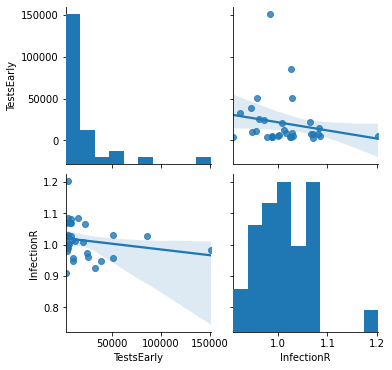

In [7]:
seaborn.pairplot(data3, vars=['TestsEarly', 'InfectionR'], kind='reg')

In [8]:
X=list(dfr2['Williamson'])
Y=list(dft3['Williamson'])
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()
print(results.t_test([1, 0]))
results.summary()

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0           4.72e+04   4581.744     10.302      0.000    3.81e+04    5.63e+04


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     16.93
Date:                Mon, 28 Sep 2020   Prob (F-statistic):           6.52e-05
Time:                        15:31:58   Log-Likelihood:                -1651.1
No. Observations:                 145   AIC:                             3306.
Df Residuals:                     143   BIC:                             3312.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        4.72e+04   4581.744     10.302      0.000    3.81e+04    5.63e+04
x1         -1.549e+04   3765.948     -4.114      0.000   -2.29e+04   -8050.717
==============================================================================
Omnibus:                       14.049   Durbin-Watson:                   0.032
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                7.850
Skew:                           0.397   Prob(JB):                       0.0197
Kurtosis:                       2.182   Cond. No.                         5.04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""